In [1]:
#Author: Tongshu Zheng from Duke University
#Email: tongshu.zheng@duke.edu; contact me if you have any questions regarding the code
#Please reference the code source and publication (i.e., "Estimating ground-level PM2.5 using micro-satellite 
#images by a convolutional neural network and random forest approach") if you use the code.

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "Project"

import os
if not (os.path.isdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)):
    print('Figure directory didn''t exist, creating now.')
    os.mkdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)
else:
    print('Figure directory exists.') 
    
def savepdf(fig,name):
    fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+name+'.pdf')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from os import listdir
from os.path import isfile, join
import tensorflow as tf
import random
import keras
from keras import applications
# from keras.utils import multi_gpu_model
from keras.optimizers import RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing import  image
import keras.utils as image
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, Conv2D, MaxPooling2D, Activation
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, Callback,LearningRateScheduler, TensorBoard, EarlyStopping
# from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input


Figure directory exists.


# Load in the Images 

In [3]:
my_X_images_folder = './X_image_Beijing'
image_files = [f for f in listdir(my_X_images_folder) if isfile(join(my_X_images_folder, f)) and '.DS_Store' not in f ]
image_files_sorted = sorted(image_files, key = lambda x: int(x.split('.')[0].split('_')[2]))

image_files_sorted

['X_image_0_20200218_0.png',
 'X_image_1_20200218_1.png',
 'X_image_2_20200218_2.png',
 'X_image_3_20200218_3.png',
 'X_image_4_20200218_4.png',
 'X_image_5_20200218_5.png',
 'X_image_6_20200218_6.png',
 'X_image_7_20200218_7.png',
 'X_image_8_20200218_8.png',
 'X_image_9_20200218_9.png',
 'X_image_10_20200220_1.png',
 'X_image_11_20200220_2.png',
 'X_image_12_20200220_3.png',
 'X_image_13_20200220_4.png',
 'X_image_14_20200220_6.png',
 'X_image_15_20200220_7.png',
 'X_image_16_20200220_8.png',
 'X_image_17_20200220_9.png',
 'X_image_18_20200223_0.png',
 'X_image_19_20200223_1.png',
 'X_image_20_20200223_2.png',
 'X_image_21_20200223_3.png',
 'X_image_22_20200223_4.png',
 'X_image_23_20200223_5.png',
 'X_image_24_20200223_6.png',
 'X_image_25_20200223_7.png',
 'X_image_26_20200223_8.png',
 'X_image_27_20200223_9.png',
 'X_image_28_20200316_1.png',
 'X_image_29_20200316_2.png',
 'X_image_30_20200316_3.png',
 'X_image_31_20200316_4.png',
 'X_image_32_20200316_6.png',
 'X_image_33_2020031

# Use keras to preprocess images so that they have the correct forms for the ImageNet CNN models later

In [4]:
def img_cropper(img, img_size):
    y,x,_ = img.shape
    startx = x//2-(img_size//2)
    starty = y//2-(img_size//2)    
    return img[starty:starty+img_size,startx:startx+img_size:,:3]

In [5]:
#image_size = 67 #200 m * 200 m model
#image_size = 167 #500 m * 500 m model
image_size = 224 #670 m * 670 m model
#image_size = 33 #100 m * 100 m model
X_image = []
for image_file in image_files_sorted:
    img = image.load_img(my_X_images_folder+'/'+image_file)
    x = image.img_to_array(img) 
    x = img_cropper(x, image_size)
    x = np.expand_dims(x, axis=0) 
    x = preprocess_input(x)
    X_image.append(x)

In [6]:
y_PM25 = []
with open("./y_PM25_Beijing/y_PM25_Beijing.txt", "r") as f:
    for line in f:
        y_PM25.append(np.float32(float(line.strip())))

In [7]:
## Train-Test Split

dataset = list(zip(X_image, y_PM25))

###shuffle dataset to get train, test datasets
random.Random(42).shuffle(dataset)
#random.shuffle(dataset)
batch_size = 100
total_batches = len(dataset) // batch_size
train_batches = int(np.ceil(8 * total_batches / 10))
test_batches = total_batches - train_batches
train, test = dataset[:train_batches*batch_size], dataset[train_batches*batch_size:]

In [8]:
X_train = np.array([item[0] for item in train]).reshape(-1,image_size,image_size,3)
X_test = np.array([item[0] for item in test]).reshape(-1,image_size,image_size,3)
y_train = np.array([item[1] for item in train]).reshape(-1)
y_test = np.array([item[1] for item in test]).reshape(-1)

# Iterative fine-tuning VGG16 for an exxample 670 m resolution model (the 500 m and 200 m models are pretty much the same)

In [9]:
VGG_finetune = VGG16(include_top=False, weights='imagenet', \
                            input_tensor=None, input_shape=(image_size, image_size, 3), pooling='max', classes=1000)

In [10]:
for layer in VGG_finetune.layers[:]:
    layer.trainable = False

In [12]:
x = VGG_finetune.output
x = Dropout(0.5)(x) # 500, 200m models = 0.1
x = Dense(128, activation="relu")(x) #500=100, 200 m =80 
x = Dropout(0.5)(x)
predictions = Dense(1, activation=None)(x)
# creating the final model 
model_final = Model(inputs = VGG_finetune.input, outputs = predictions)
model_final.compile(optimizer=optimizers.Adam(), loss='mean_squared_error', metrics=['mse'])

model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
train_datagen = ImageDataGenerator(
                rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, zoom_range = 0.5,\
                            fill_mode = 'reflect', horizontal_flip = True,vertical_flip=True, channel_shift_range = 0)

test_datagen = ImageDataGenerator()

In [14]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
validation_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

In [15]:
checkpoint = ModelCheckpoint(filepath='./checkpoint_VGG16_finetune_670m/checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
#early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
history = LossHistory()

In [16]:
model_final.fit_generator(train_generator, steps_per_epoch=len(X_train)//batch_size, epochs=60, verbose=1, callbacks=[checkpoint,history], validation_data=validation_generator, validation_steps=len(y_train)//batch_size
              )

C:\Users\benny\AppData\Local\Temp\ipykernel_26464\3539016524.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_final.fit_generator(train_generator, steps_per_epoch=len(X_train)//batch_size, epochs=60, verbose=1, callbacks=[checkpoint,history], validation_data=validation_generator, validation_steps=len(y_train)//batch_size


Epoch 1/60
1/1 [==============================] - ETA: 0s - loss: 12131.6875 - mse: 12131.6875
Epoch 1: saving model to ./checkpoint_VGG16_finetune_670m\checkpoint-01-1122.46.hdf5
1/1 [==============================] - 14s 14s/step - loss: 12131.6875 - mse: 12131.6875 - val_loss: 1122.4645 - val_mse: 1122.4645
Epoch 2/60
1/1 [==============================] - ETA: 0s - loss: 5267.9062 - mse: 5267.9062
Epoch 2: saving model to ./checkpoint_VGG16_finetune_670m\checkpoint-02-1060.92.hdf5
1/1 [==============================] - 1s 1s/step - loss: 5267.9062 - mse: 5267.9062 - val_loss: 1060.9202 - val_mse: 1060.9202
Epoch 3/60
1/1 [==============================] - ETA: 0s - loss: 2855.0186 - mse: 2855.0186
Epoch 3: saving model to ./checkpoint_VGG16_finetune_670m\checkpoint-03-3724.75.hdf5
1/1 [==============================] - 1s 1s/step - loss: 2855.0186 - mse: 2855.0186 - val_loss: 3724.7500 - val_mse: 3724.7500
Epoch 4/60
1/1 [==============================] - ETA: 0s - loss: 5102.8936 

# What about retrain the last conv. layer

In [17]:
VGG_finetune = VGG16(include_top=False, weights='imagenet', \
                            input_tensor=None, input_shape=(image_size, image_size, 3), pooling='max', classes=1000)

In [18]:
for layer in VGG_finetune.layers[:-3]:
    layer.trainable = False
for layer in VGG_finetune.layers[-3:]:
    layer.trainable = True

In [19]:
VGG_finetune.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
# load your best model from the last training here
model = load_model('./checkpoint_VGG16_finetune_670m/checkpoint-31-140.71.hdf5') #670m

In [22]:
weights_128 = model.layers[-3].get_weights()

weights_1 = model.layers[-1].get_weights()

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# then

In [25]:
x = VGG_finetune.output
x = Dropout(0.5)(x)
x = Dense(128, activation="relu",weights = weights_128)(x) 
x = Dropout(0.5)(x)
predictions = Dense(1, activation=None, weights = weights_1)(x)
# creating the final model 
model_final = Model(inputs = VGG_finetune.input, outputs = predictions)
model_final.compile(optimizer=optimizers.Adam(), loss='mean_squared_error', metrics=['mse'])

model_final.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [26]:
for layer in model_final.layers[-3:]:
    layer.trainable = False

In [27]:
model_final.compile(optimizer=optimizers.Adam(), loss='mean_squared_error', metrics=['mse'])

model_final.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [28]:
train_datagen = ImageDataGenerator(
                rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, zoom_range = 0.5,\
                            fill_mode = 'reflect', horizontal_flip = True,vertical_flip=True, channel_shift_range = 0)

test_datagen = ImageDataGenerator()

In [29]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
validation_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

In [30]:
checkpoint = ModelCheckpoint(filepath='./checkpoint_VGG16_finetune_670m_last_conv/checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
#early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
history = LossHistory()

In [31]:
model_final.fit_generator(train_generator, steps_per_epoch=len(X_train)//batch_size, epochs=60, verbose=1, callbacks=[checkpoint,history], validation_data=validation_generator, validation_steps=len(y_train)//batch_size
              )

C:\Users\benny\AppData\Local\Temp\ipykernel_26464\3539016524.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_final.fit_generator(train_generator, steps_per_epoch=len(X_train)//batch_size, epochs=60, verbose=1, callbacks=[checkpoint,history], validation_data=validation_generator, validation_steps=len(y_train)//batch_size


Epoch 1/60
1/1 [==============================] - ETA: 0s - loss: 686.4801 - mse: 686.4801
Epoch 1: saving model to ./checkpoint_VGG16_finetune_670m_last_conv\checkpoint-01-441.19.hdf5
1/1 [==============================] - 3s 3s/step - loss: 686.4801 - mse: 686.4801 - val_loss: 441.1886 - val_mse: 441.1886
Epoch 2/60
1/1 [==============================] - ETA: 0s - loss: 894.2124 - mse: 894.2124
Epoch 2: saving model to ./checkpoint_VGG16_finetune_670m_last_conv\checkpoint-02-384.73.hdf5
1/1 [==============================] - 1s 1s/step - loss: 894.2124 - mse: 894.2124 - val_loss: 384.7342 - val_mse: 384.7342
Epoch 3/60
1/1 [==============================] - ETA: 0s - loss: 1313.8417 - mse: 1313.8417
Epoch 3: saving model to ./checkpoint_VGG16_finetune_670m_last_conv\checkpoint-03-126.16.hdf5
1/1 [==============================] - 1s 1s/step - loss: 1313.8417 - mse: 1313.8417 - val_loss: 126.1572 - val_mse: 126.1572
Epoch 4/60
1/1 [==============================] - ETA: 0s - loss: 727

# What about further retraining the second to last conv. layer?

In [32]:
# again load your best model from the last training here
model = load_model('./checkpoint_VGG16_finetune_670m_last_conv/checkpoint-03-126.16.hdf5') #670m

In [33]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [34]:
weights_lastconv = model.layers[-7].get_weights()

In [35]:
VGG_finetune = VGG16(include_top=False, weights='imagenet', \
                            input_tensor=None, input_shape=(image_size, image_size, 3), pooling='max', classes=1000)

In [36]:
for layer in VGG_finetune.layers[:-4]:
    layer.trainable = False
for layer in VGG_finetune.layers[-3:]:
    layer.trainable = False

In [37]:
VGG_finetune.layers[-3].set_weights(weights_lastconv)

In [38]:
VGG_finetune.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [39]:
weights_128 = model.layers[-3].get_weights()
weights_1 = model.layers[-1].get_weights()

# then

In [40]:
x = VGG_finetune.output
x = Dropout(0.5)(x)
x = Dense(128, activation="relu",  weights = weights_128)(x) #500m = 100
x = Dropout(0.5)(x)
predictions = Dense(1, activation=None, weights = weights_1)(x)
# creating the final model 
model_final = Model(inputs = VGG_finetune.input, outputs = predictions)
model_final.compile(optimizer=optimizers.Adam(), loss='mean_squared_error', metrics=['mse'])

model_final.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [41]:
for layer in model_final.layers[-3:]:
    layer.trainable = False

In [42]:
model_final.compile(optimizer=optimizers.Adam(), loss='mean_squared_error', metrics=['mse'])

model_final.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [43]:
train_datagen = ImageDataGenerator(
                rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, zoom_range = 0.5,\
                            fill_mode = 'reflect', horizontal_flip = True,vertical_flip=True, channel_shift_range = 0)

test_datagen = ImageDataGenerator()

In [44]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
validation_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

In [45]:
checkpoint = ModelCheckpoint(filepath='./checkpoint_VGG16_finetune_670m_seclast_conv/checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
#early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
history = LossHistory()

In [46]:
model_final.fit_generator(train_generator, steps_per_epoch=len(X_train)//batch_size, epochs=60, verbose=1, callbacks=[checkpoint,history], validation_data=validation_generator, validation_steps=len(y_train)//batch_size
              )

C:\Users\benny\AppData\Local\Temp\ipykernel_26464\3539016524.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_final.fit_generator(train_generator, steps_per_epoch=len(X_train)//batch_size, epochs=60, verbose=1, callbacks=[checkpoint,history], validation_data=validation_generator, validation_steps=len(y_train)//batch_size


Epoch 1/60
1/1 [==============================] - ETA: 0s - loss: 739.4685 - mse: 739.4685
Epoch 1: saving model to ./checkpoint_VGG16_finetune_670m_seclast_conv\checkpoint-01-829.40.hdf5
1/1 [==============================] - 2s 2s/step - loss: 739.4685 - mse: 739.4685 - val_loss: 829.3963 - val_mse: 829.3963
Epoch 2/60
1/1 [==============================] - ETA: 0s - loss: 1321.1569 - mse: 1321.1569
Epoch 2: saving model to ./checkpoint_VGG16_finetune_670m_seclast_conv\checkpoint-02-124.52.hdf5
1/1 [==============================] - 1s 1s/step - loss: 1321.1569 - mse: 1321.1569 - val_loss: 124.5188 - val_mse: 124.5188
Epoch 3/60
1/1 [==============================] - ETA: 0s - loss: 763.3203 - mse: 763.3203
Epoch 3: saving model to ./checkpoint_VGG16_finetune_670m_seclast_conv\checkpoint-03-332.19.hdf5
1/1 [==============================] - 1s 1s/step - loss: 763.3203 - mse: 763.3203 - val_loss: 332.1920 - val_mse: 332.1920
Epoch 4/60
1/1 [==============================] - ETA: 0s - 

# What about further retraining the third to last conv. layer?


In [47]:
# again load your best model from the last training here
model = load_model('./checkpoint_VGG16_finetune_670m_seclast_conv/checkpoint-35-56.48.hdf5') #670m

In [48]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [49]:
weights_lastconv = model.layers[-7].get_weights()

In [50]:
weights_2tolastconv = model.layers[-8].get_weights()

In [51]:
weights_128 = model.layers[-3].get_weights()
weights_1 = model.layers[-1].get_weights()

In [52]:
VGG_finetune = VGG16(include_top=False, weights='imagenet', \
                            input_tensor=None, input_shape=(image_size, image_size, 3), pooling='max', classes=1000)

In [53]:
for layer in VGG_finetune.layers[:-5]:
    layer.trainable = False
for layer in VGG_finetune.layers[-4:]:
    layer.trainable = False

In [54]:
VGG_finetune.layers[-3].set_weights(weights_lastconv)
VGG_finetune.layers[-4].set_weights(weights_2tolastconv)

In [55]:
VGG_finetune.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# then

In [59]:
x = VGG_finetune.output
x = Dropout(0.5)(x)
x = Dense(128, activation="relu", weights = weights_128)(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation=None, weights = weights_1)(x)
# creating the final model 
model_final = Model(inputs = VGG_finetune.input, outputs = predictions)

In [60]:
for layer in model_final.layers[-3:]:
    layer.trainable = False

In [61]:
model_final.compile(optimizer=optimizers.Adam(), loss='mean_squared_error', metrics=['mse'])


In [62]:
model_final.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [63]:
train_datagen = ImageDataGenerator(
                rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, zoom_range = 0.5,\
                            fill_mode = 'reflect', horizontal_flip = True,vertical_flip=True, channel_shift_range = 0)
test_datagen = ImageDataGenerator()

In [64]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
validation_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

In [65]:
checkpoint = ModelCheckpoint(filepath='./checkpoint_VGG16_finetune_670m_thirdlast_conv/checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
#early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
history = LossHistory()

In [66]:
model_final.fit_generator(train_generator, steps_per_epoch=len(X_train)//batch_size, epochs=80, verbose=1, callbacks=[checkpoint,history], validation_data=validation_generator, validation_steps=len(y_train)//batch_size
              )

C:\Users\benny\AppData\Local\Temp\ipykernel_26464\1802957179.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_final.fit_generator(train_generator, steps_per_epoch=len(X_train)//batch_size, epochs=80, verbose=1, callbacks=[checkpoint,history], validation_data=validation_generator, validation_steps=len(y_train)//batch_size


Epoch 1/80
1/1 [==============================] - ETA: 0s - loss: 409.4261 - mse: 409.4261
Epoch 1: saving model to ./checkpoint_VGG16_finetune_670m_thirdlast_conv\checkpoint-01-627.68.hdf5
1/1 [==============================] - 2s 2s/step - loss: 409.4261 - mse: 409.4261 - val_loss: 627.6820 - val_mse: 627.6820
Epoch 2/80
1/1 [==============================] - ETA: 0s - loss: 1114.4188 - mse: 1114.4188
Epoch 2: saving model to ./checkpoint_VGG16_finetune_670m_thirdlast_conv\checkpoint-02-687.31.hdf5
1/1 [==============================] - 1s 1s/step - loss: 1114.4188 - mse: 1114.4188 - val_loss: 687.3127 - val_mse: 687.3127
Epoch 3/80
1/1 [==============================] - ETA: 0s - loss: 1842.0508 - mse: 1842.0508
Epoch 3: saving model to ./checkpoint_VGG16_finetune_670m_thirdlast_conv\checkpoint-03-130.90.hdf5
1/1 [==============================] - 1s 1s/step - loss: 1842.0508 - mse: 1842.0508 - val_loss: 130.9000 - val_mse: 130.9000
Epoch 4/80
1/1 [==============================] - 

# RF part and final Model Evaluation

In [67]:
# load the final best model here!

#670m
model = load_model('./checkpoint_VGG16_finetune_670m_thirdlast_conv/checkpoint-25-59.39.hdf5')


In [69]:
model.summary()
extract_model = Model(inputs=model.input, outputs=model.get_layer('dense_17').output) #may not be dense_1,
# should be the dense layer with dimension 128 for 670 m model

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [70]:
X_image_features = extract_model.predict(np.array(X_image).reshape(-1,image_size,image_size,3))

5/5 [==============================] - 3s 221ms/step


In [71]:
len(X_image_features)

137

In [72]:
np.shape(X_image_features)

(137, 1)

In [73]:
X_image_features



array([[42.507896],
       [29.486132],
       [43.954926],
       [37.772766],
       [43.987724],
       [43.83392 ],
       [38.88664 ],
       [41.755157],
       [38.772667],
       [45.26279 ],
       [34.238697],
       [44.208652],
       [36.50818 ],
       [41.300278],
       [36.937057],
       [44.814137],
       [39.30225 ],
       [39.678696],
       [40.43998 ],
       [30.990257],
       [52.485657],
       [36.961773],
       [38.696636],
       [44.91182 ],
       [38.859985],
       [39.631386],
       [42.38987 ],
       [40.842045],
       [33.567635],
       [48.19822 ],
       [37.73917 ],
       [44.85727 ],
       [38.19964 ],
       [44.07587 ],
       [41.692924],
       [40.346783],
       [50.291115],
       [41.909897],
       [51.211006],
       [51.520744],
       [42.90078 ],
       [58.623505],
       [43.604637],
       [46.68466 ],
       [39.831276],
       [42.575825],
       [39.710335],
       [44.617332],
       [63.223705],
       [40.72984 ],


# What if I use meteorology features?

In [75]:
meteo_feature = np.load('meteo_feature_Beijing.npy')

In [76]:
len(meteo_feature)

137

In [77]:
features_meteo = np.append(X_image_features,meteo_feature,axis = 1)

In [78]:
mask = ~np.any(np.isnan(features_meteo), axis=1)
features_meteo = features_meteo[mask]

In [80]:
y_all= np.array(y_PM25).reshape([137,-1])[mask]

In [81]:
np.shape(features_meteo)

(137, 5)

In [82]:
y_all

array([[32.446945],
       [29.321321],
       [34.3675  ],
       [29.2397  ],
       [30.578333],
       [32.93861 ],
       [32.8825  ],
       [31.414167],
       [29.640278],
       [29.974167],
       [31.023233],
       [35.59    ],
       [34.94984 ],
       [31.943605],
       [34.015   ],
       [29.424444],
       [31.021389],
       [31.388472],
       [50.6225  ],
       [47.795277],
       [54.226387],
       [43.383938],
       [47.74389 ],
       [51.789165],
       [50.83889 ],
       [42.56139 ],
       [45.40278 ],
       [45.516945],
       [41.845   ],
       [41.015   ],
       [42.247776],
       [44.003613],
       [44.02639 ],
       [41.188057],
       [38.994644],
       [39.22778 ],
       [55.12528 ],
       [55.704723],
       [53.949444],
       [53.869106],
       [57.642044],
       [57.1477  ],
       [57.207222],
       [54.291866],
       [50.51161 ],
       [53.840908],
       [60.833057],
       [38.640278],
       [56.369446],
       [25.374722],


## Random Forest Regression

In [83]:
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn import metrics
import pandas as pd
import scipy
from sklearn.neighbors import LocalOutlierFactor
from datetime import datetime
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [84]:
## load in site labels and time index to see the seasonal trend and site-specific trend
time_stamps = np.load('time_stamp_Beijing.npy')
site_labels = np.load('site_label_Beijing.npy')

In [85]:
time_stamps = np.array([float(x) for x in time_stamps ])
site_labels = np.array([float(x) for x in site_labels ])

In [87]:
features_meteo = np.append(features_meteo,time_stamps.reshape(137,1),axis = 1)
features_meteo = np.append(features_meteo,site_labels.reshape(137,1),axis = 1)

In [88]:
features_meteo

array([[4.25078964e+01, 5.60185185e+00, 4.82500000e+01, 5.20833333e+00,
        3.04458333e+01, 2.02002180e+07, 0.00000000e+00],
       [2.94861317e+01, 5.60185185e+00, 4.82500000e+01, 5.20833333e+00,
        3.04458333e+01, 2.02002180e+07, 1.00000000e+00],
       [4.39549255e+01, 5.60185185e+00, 4.82500000e+01, 5.20833333e+00,
        3.04458333e+01, 2.02002180e+07, 2.00000000e+00],
       [3.77727661e+01, 5.60185185e+00, 4.82500000e+01, 5.20833333e+00,
        3.04458333e+01, 2.02002180e+07, 3.00000000e+00],
       [4.39877243e+01, 5.60185185e+00, 4.82500000e+01, 5.20833333e+00,
        3.04458333e+01, 2.02002180e+07, 4.00000000e+00],
       [4.38339195e+01, 5.60185185e+00, 4.82500000e+01, 5.20833333e+00,
        3.04458333e+01, 2.02002180e+07, 5.00000000e+00],
       [3.88866386e+01, 5.60185185e+00, 4.82500000e+01, 5.20833333e+00,
        3.04458333e+01, 2.02002180e+07, 6.00000000e+00],
       [4.17551575e+01, 5.60185185e+00, 4.82500000e+01, 5.20833333e+00,
        3.04458333e+01, 2

# Try to match RF's train test splits with the CNN's splits

In [89]:
dataset_RF = list(zip(features_meteo, y_all))

###shuffle dataset to get train, test datasets
random.Random(42).shuffle(dataset_RF)


batch_size = 100
total_batches = len(dataset_RF) // batch_size
train_batches = int(np.ceil(8 * total_batches / 10))
test_batches = total_batches - train_batches

In [90]:
train_full, test_full = dataset_RF[:train_batches*batch_size], dataset_RF[train_batches*batch_size:]
X_train_full = np.array([x[0] for x in train_full])
X_test_full = np.array([x[0] for x in test_full])
y_train = np.array([x[1] for x in train_full])
y_test = np.array([x[1] for x in test_full])
X_train = X_train_full[:, :-2]
X_test = X_test_full[:, :-2]

In [91]:
np.mean(y_test)

41.66627

In [93]:
shuffle=KFold(n_splits=5, shuffle=True,random_state=42)
max_features=['sqrt']
n_estimators=['300','400','500']
#min_samples_leaf=np.linspace(2,8,3)
min_samples_leaf=['1','2','3']
avg_MSE=np.zeros([len(max_features),len(n_estimators),len(min_samples_leaf)])
avg_MAE = np.zeros([len(max_features),len(n_estimators),len(min_samples_leaf)])
for k, feature in enumerate(max_features):
    for i,estimators in enumerate(n_estimators):
        for j,samples_leaf in enumerate(min_samples_leaf):
            print('k = '+str(k)+', i = '+str(i)+', j = '+str(j)+' started.')
            scaler=StandardScaler()
            cls = RandomForestRegressor(bootstrap=True, n_jobs=-1, random_state = 40,max_features =feature,n_estimators =int(estimators),min_samples_leaf=int(samples_leaf ) )
            our_pipeline=Pipeline([('scaler',scaler),('cls',cls)])
            MSE = -cross_val_score(our_pipeline,X_train, y_train.ravel(), cv=shuffle, scoring='neg_mean_squared_error')
            avg_MSE[k,i,j]=np.mean(MSE)
            #MAE = -cross_val_score(our_pipeline,X_train, y_train.ravel(), cv=shuffle, scoring='neg_mean_absolute_error')
            #avg_MAE[k,i,j]=np.mean(MAE)
            print('k = '+str(k)+', i = '+str(i)+', j = '+str(j)+' finished.')

k = 0, i = 0, j = 0 started.
k = 0, i = 0, j = 0 finished.
k = 0, i = 0, j = 1 started.
k = 0, i = 0, j = 1 finished.
k = 0, i = 0, j = 2 started.
k = 0, i = 0, j = 2 finished.
k = 0, i = 1, j = 0 started.
k = 0, i = 1, j = 0 finished.
k = 0, i = 1, j = 1 started.
k = 0, i = 1, j = 1 finished.
k = 0, i = 1, j = 2 started.
k = 0, i = 1, j = 2 finished.
k = 0, i = 2, j = 0 started.
k = 0, i = 2, j = 0 finished.
k = 0, i = 2, j = 1 started.
k = 0, i = 2, j = 1 finished.
k = 0, i = 2, j = 2 started.
k = 0, i = 2, j = 2 finished.


In [94]:
np.sqrt(avg_MSE)

array([[[4.30968878, 4.39235272, 4.81066787],
        [4.30707545, 4.37264231, 4.80961424],
        [4.31876795, 4.38435474, 4.79368637]]])

# Compute 5-fold results

In [103]:
cv = KFold(n_splits=5, shuffle=True,random_state=42)
def final_cv_results(X,y):
    CV5_spearman = []
    CV5_pearson = []
    CV5_MAE = []
    CV5_NMAE = []
    CV5_RMSE = []
    CV5_NRMSE = []
    for train_index, test_index in cv.split(X, y):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        scaler=StandardScaler()
        cls = RandomForestRegressor(bootstrap=True, n_jobs=-1, random_state = 40,max_features ='sqrt',n_estimators =500,min_samples_leaf=1 )
        our_pipeline=Pipeline([('scaler',scaler),('cls',cls)])
        our_pipeline.fit(X_train,y_train.ravel())
        CV5_spearman.append(stats.spearmanr((our_pipeline.predict(X_test)),y_test.ravel())[0])
        CV5_pearson.append(stats.pearsonr((our_pipeline.predict(X_test)),y_test.ravel())[0])
        my_prediction = our_pipeline.predict(X_test)
        RMSE = round(np.sqrt(metrics.mean_squared_error(y_test, my_prediction)),1)
        MAE = round(metrics.mean_absolute_error(y_test, my_prediction),1)
        CV5_MAE.append(MAE)
        CV5_NMAE.append(MAE/np.mean(y_test))
        CV5_RMSE.append(RMSE)
        CV5_NRMSE.append(RMSE/np.mean(y_test))

    return  CV5_spearman, CV5_pearson, CV5_MAE, CV5_NMAE, CV5_RMSE, CV5_NRMSE


In [104]:
 CV5_spearman, CV5_pearson, CV5_MAE, CV5_NMAE, CV5_RMSE, CV5_NRMSE = final_cv_results(X_train,y_train)

TRAIN: [ 1  2  3  5  6  7  8  9 11 13 14 15 16 17 19 20 21 23 24 25 26 27 28 29
 32 34 35 36 37 38 40 41 42 43 46 47 48 49 50 51 52 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68 69 71 72 74 75 78 79 81 82 84 85 86 87 88 89 91
 92 93 94 95 96 97 98 99] TEST: [ 0  4 10 12 18 22 30 31 33 39 44 45 53 70 73 76 77 80 83 90]
TRAIN: [ 0  1  2  3  4  6  7  8 10 12 13 14 17 18 19 20 21 22 23 24 25 27 29 30
 31 32 33 34 36 37 38 39 41 43 44 45 46 48 49 50 51 52 53 54 56 57 58 59
 60 61 62 63 64 67 68 70 71 73 74 75 76 77 78 79 80 81 82 83 84 86 87 89
 90 91 92 94 95 97 98 99] TEST: [ 5  9 11 15 16 26 28 35 40 42 47 55 65 66 69 72 85 88 93 96]
TRAIN: [ 0  1  2  4  5  9 10 11 12 14 15 16 18 20 21 22 23 26 28 29 30 31 32 33
 35 37 39 40 41 42 43 44 45 46 47 48 50 51 52 53 54 55 56 57 58 59 60 61
 63 65 66 67 68 69 70 71 72 73 74 75 76 77 79 80 82 83 84 85 86 87 88 90
 91 92 93 94 96 97 98 99] TEST: [ 3  6  7  8 13 17 19 24 25 27 34 36 38 49 62 64 78 81 89 95]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10

In [105]:
CV5_mean = [np.mean(CV5_spearman),np.mean(CV5_pearson),np.mean(CV5_MAE), np.mean(CV5_NMAE), np.mean(CV5_RMSE), np.mean(CV5_NRMSE) ]

In [106]:
CV5_mean

[0.8833082706766916,
 0.9434007512379379,
 3.0,
 0.07123332782525878,
 4.180000000000001,
 0.09937992669206637]

# Illustrating 5-fold CV results

In [107]:
from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

In [108]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=40):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)
    for ii, value in enumerate(['Fold 0', 'Fold 1', 'Fold 2', 'Fold 3', 'Fold 4']):
        plt.text(1000+2000*ii, 6-0.4,value,horizontalalignment='center', fontsize=20, rotation=0, color ='black' )
    for ii, value in enumerate(CV5_spearman):
        plt.text(1000+2000*ii, 7-0.4,round(value,2),horizontalalignment='center', fontsize=20, rotation=0, color ='black' )
    for ii, value in enumerate(CV5_pearson):
        plt.text(1000+2000*ii, 8-0.4,round(value,2),horizontalalignment='center', fontsize=20, rotation=0, color ='black' )
    for ii, value in enumerate(CV5_MAE):
        plt.text(1000+2000*ii, 9-0.4,round(value,1),horizontalalignment='center', fontsize=20, rotation=0, color ='black' )
    for ii, value in enumerate(CV5_NMAE):
        plt.text(1000+2000*ii, 10-0.4,str(round(value*100,1))+'%',horizontalalignment='center', fontsize=20, rotation=0, color ='black' )
    for ii, value in enumerate(CV5_RMSE):
        plt.text(1000+2000*ii, 11-0.4,round(value,1),horizontalalignment='center', fontsize=20, rotation=0, color ='black' )
    for ii, value in enumerate(CV5_NRMSE):
        plt.text(1000+2000*ii, 12-0.4,str(round(value*100,1))+'%',horizontalalignment='center', fontsize=20, rotation=0, color ='black' )
    ''' 
    for ii, value in enumerate(CV5_mean):
        if ii==0 or 1:
            plt.text(1000+2000*ii, 12-0.2,round(value,2),horizontalalignment='center', fontsize=15, rotation=0, color ='black' )
        elif ii==2 or 4:
            plt.text(1000+2000*ii, 12-0.2,round(value,1),horizontalalignment='center', fontsize=15, rotation=0, color ='black' )

        else:
            plt.text(1000+2000*ii, 12-0.2,str(round(value*100,1))+'%',horizontalalignment='center', fontsize=15, rotation=0, color ='black' )
    '''
    # Plot the data classes and groups at the end
    #ax.scatter(range(len(X)), [ii + 1.5] * len(X),
    #           c=y, marker='_', lw=lw, cmap=cmap_data)

    #ax.scatter(range(len(X)), [ii + 2.5] * len(X),
    #           c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['Folds','Spearman r','Pearson r','MAE', 'NMAE','RMSE','NRMSE']
    ax.set(yticks=np.arange(n_splits+7) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+7.2, -.2], xlim=[0, len(X)])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['CV test', 'CV training'], loc=(-0.5, 0.8), fontsize=20)
    ax.set_title('5-fold CV results on the Beijing training set', fontsize=20)
    ax.tick_params(labelsize = 20)
    ax.set_xlabel('Sample index',size = 20)
    ax.set_ylabel("CV iteration", size = 20)
    plt.tight_layout()
    return ax

C:\Users\benny\AppData\Local\Temp\ipykernel_26464\3321159169.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


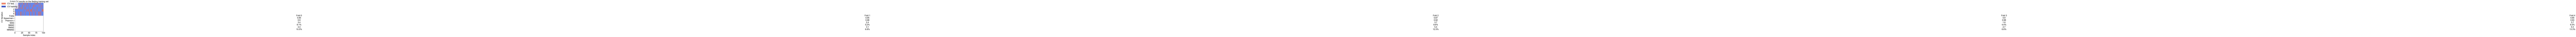

In [110]:
n_splits = 5
fig, ax = plt.subplots(figsize = (5,5))
cv = KFold(n_splits=5, shuffle=True,random_state=42)
plot_cv_indices(cv, X_train, y_train, ax, n_splits)

savepdf(fig,'cv_results')

# Build the model based on your best hyperparameters

In [112]:
#500 1 for VGG fine-tuning
scaler=StandardScaler()
cls = RandomForestRegressor(bootstrap=True, n_jobs=-1, random_state = 40,max_features ='sqrt',n_estimators =500,min_samples_leaf=1 )
our_pipeline=Pipeline([('scaler',scaler),('cls',cls)])
our_pipeline.fit(X_train,y_train.ravel())

Pipeline(steps=[('scaler', StandardScaler()),
                ('cls',
                 RandomForestRegressor(max_features='sqrt', n_estimators=500,
                                       n_jobs=-1, random_state=40))])

# Visualization

In [113]:
Rsquared = stats.spearmanr((our_pipeline.predict(X_train)),y_train.ravel())[0]
pvalue = stats.spearmanr((our_pipeline.predict(X_train)),y_train.ravel())[1]
Rsquared_pearson = stats.pearsonr((our_pipeline.predict(X_train)),y_train.ravel())[0]
pvalue_pearson = stats.pearsonr((our_pipeline.predict(X_train)),y_train.ravel())[1]

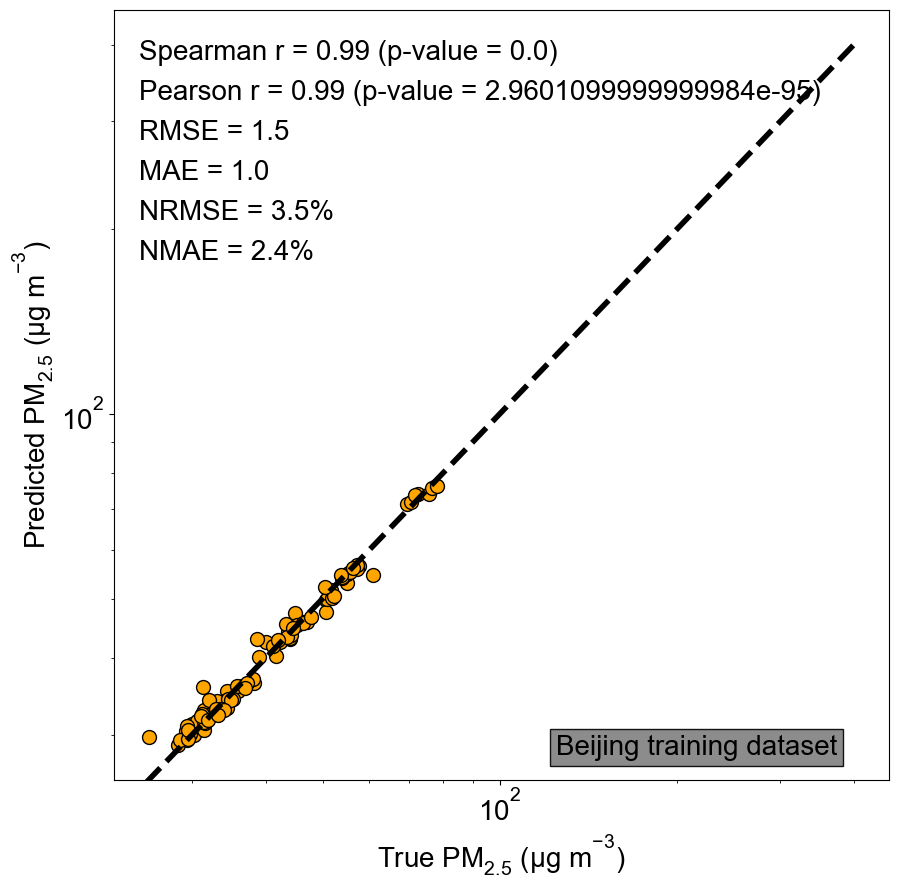

In [114]:
plt.rcParams.update({'mathtext.default':  'regular' })
my_prediction = our_pipeline.predict(X_train)
RMSE = round(np.sqrt(metrics.mean_squared_error(y_train, my_prediction)),1)
MAE = round(metrics.mean_absolute_error(y_train, my_prediction),1)
fig, ax = plt.subplots(figsize = (10,10))
ax.set_yscale('log')
ax.set_xscale('log')
ax.scatter(y_train, my_prediction,color = 'orange', edgecolors=(0, 0, 0),  s = 100)
ax.plot([0, 400], [0, 400], 'k--', lw=4)
ax.set_xlabel('True $PM_{2.5}$ ($\mu $g m$^{-3}$)', size = 20)
ax.set_ylabel('Predicted $PM_{2.5}$ ($\mu $g m$^{-3}$)', size = 20)
ax.tick_params(labelsize = 20)
fig.text(0.15, 0.83, 'Spearman r = '+ str(round(Rsquared,2)) + ' (p-value = '+ str(round(pvalue,7))+')', color='black', weight='roman',
fontsize=20)

plt.axis('tight')
fig.text(0.15, 0.79, 'Pearson r = '+ str(round(Rsquared_pearson,2)) + ' (p-value = '+ str(round(pvalue_pearson,100)) + ')', color='black', weight='roman',
fontsize=20)

fig.text(0.15, 0.75, 'RMSE = '+ str(RMSE), color='black', weight='roman',
fontsize=20)
fig.text(0.15, 0.71, 'MAE = '+ str(MAE), color='black', weight='roman',
fontsize=20)
fig.text(0.15, 0.67, 'NRMSE = '+ str(round(RMSE/np.mean(y_train)*100,1))+'%', color='black', weight='roman',
fontsize=20)
fig.text(0.15, 0.63, 'NMAE = '+ str(round(MAE/np.mean(y_train)*100,1))+'%', color='black', weight='roman',
fontsize=20)
fig.text(0.567, 0.135, 'Beijing training dataset', bbox=dict(facecolor='grey', alpha=0.9),color='black', weight='roman',
fontsize=20)

#plt.gca().set_aspect('equal', adjustable='box')
plt.show()
#savepdf(fig,'Satellite_Beijing_VGGtune_training_best')

In [115]:
Rsquared = stats.spearmanr((our_pipeline.predict(X_test)),y_test.ravel())[0]
pvalue = stats.spearmanr((our_pipeline.predict(X_test)),y_test.ravel())[1]
Rsquared_pearson = stats.pearsonr((our_pipeline.predict(X_test)),y_test.ravel())[0]
pvalue_pearson = stats.pearsonr((our_pipeline.predict(X_test)),y_test.ravel())[1]

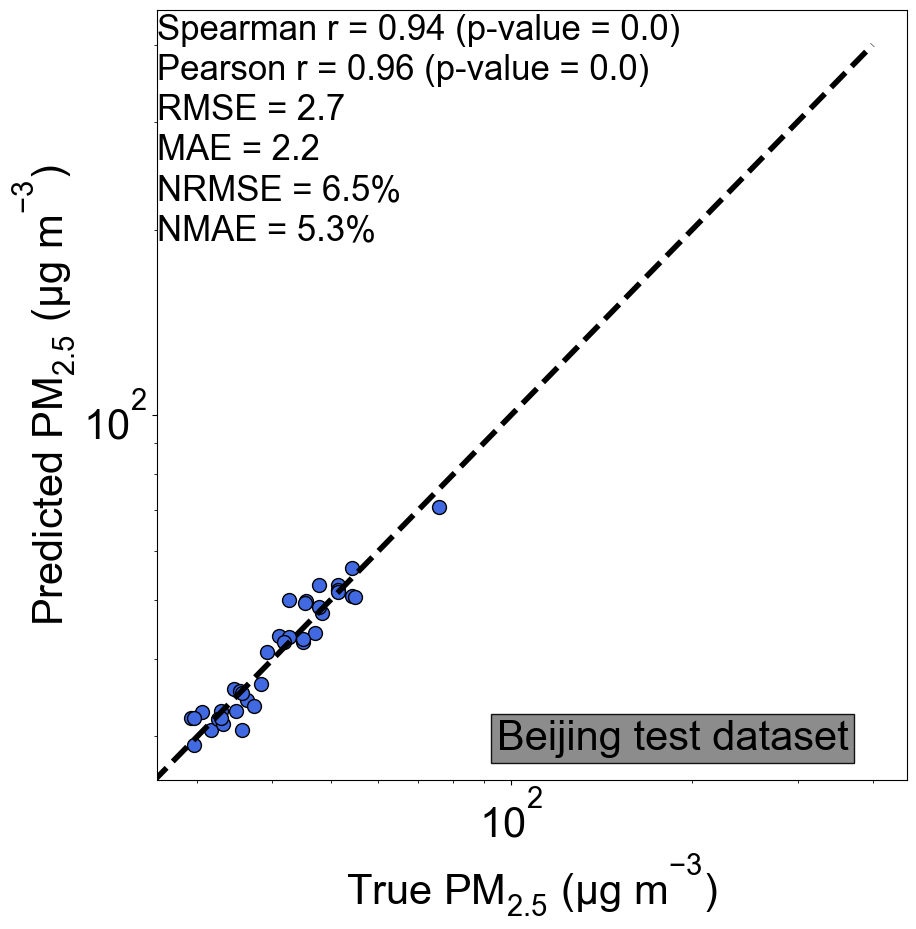

In [116]:
plt.rcParams.update({'mathtext.default':  'regular' })
my_prediction = our_pipeline.predict(X_test)
RMSE = round(np.sqrt(metrics.mean_squared_error(y_test, my_prediction)),1)
MAE = round(metrics.mean_absolute_error(y_test, my_prediction),1)
fig, ax = plt.subplots(figsize = (10,10))
ax.set_yscale('log')
ax.set_xscale('log')
ax.scatter(y_test, my_prediction, color = 'royalblue',edgecolors=(0, 0, 0), s = 100)
ax.plot([0, 400], [0, 400], 'k--', lw=4)
ax.set_xlabel('True $PM_{2.5}$ ($\mu $g m$^{-3}$)', size = 30)
ax.set_ylabel('Predicted $PM_{2.5}$ ($\mu $g m$^{-3}$)', size = 30)
ax.tick_params(labelsize = 30)
fig.text(0.15, 0.85, 'Spearman r = '+ str(round(Rsquared,2)) + ' (p-value = '+ str(round(pvalue,7))+')', color='black', weight='roman',
fontsize=25)

plt.axis('tight')
fig.text(0.15, 0.81, 'Pearson r = '+ str(round(Rsquared_pearson,2)) + ' (p-value = '+ str(round(pvalue_pearson,2)) + ')', color='black', weight='roman',
fontsize=25)

fig.text(0.15, 0.77, 'RMSE = '+ str(RMSE), color='black', weight='roman',
fontsize=25)
fig.text(0.15, 0.73, 'MAE = '+ str(MAE), color='black', weight='roman',
fontsize=25)
fig.text(0.15, 0.69, 'NRMSE = '+ str(round(RMSE/np.mean(y_test)*100,1))+'%', color='black', weight='roman',
fontsize=25)
fig.text(0.15, 0.65, 'NMAE = '+ str(round(MAE/np.mean(y_test)*100,1))+'%', color='black', weight='roman',
fontsize=25)
fig.text(0.49, 0.14, 'Beijing test dataset', bbox=dict(facecolor='grey', alpha=0.9),color='black', weight='roman',
fontsize=30)
#plt.gca().set_aspect('equal', adjustable='box')
plt.gcf().subplots_adjust(left=0.15)
plt.show()
savepdf(fig,'Satellite_Beijing_VGGtune_test_best')
#savepdf(fig,'Satellite_Beijing_VGG16')

# RF Importance

In [117]:
importances = cls.feature_importances_

std = np.std([tree.feature_importances_ for tree in cls.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

importances

#indices[:10]

importance_indices = []
for i in range(128):
    importance_indices.append('Image_'+str(i))
importance_indices.append('Temperature')
importance_indices.append('RH')
importance_indices.append('Wind speed')
importance_indices.append('SLP')

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (10,) and arg 1 with shape (5,).

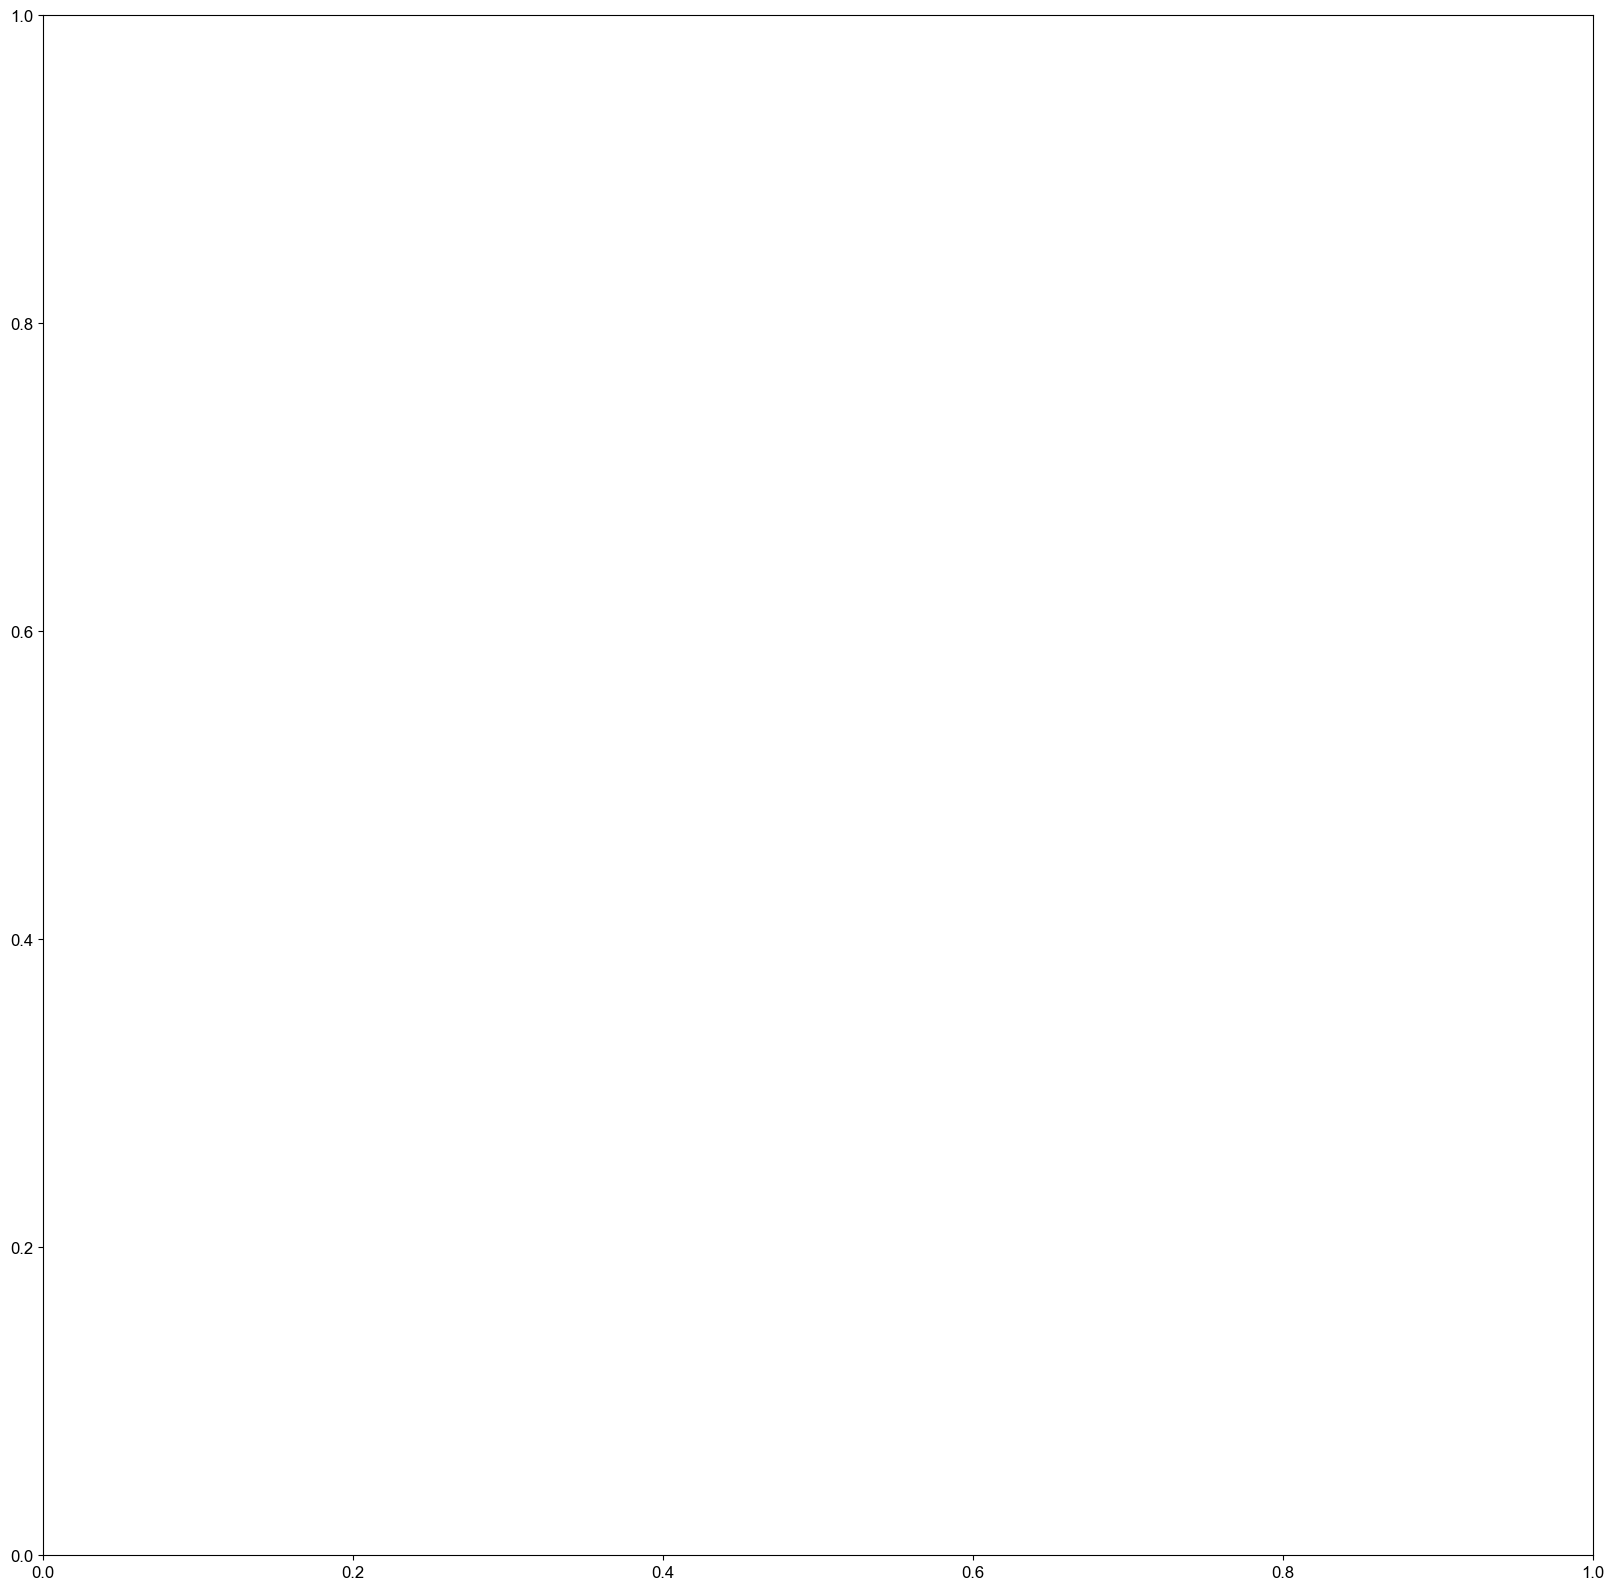

In [118]:
fig=plt.figure(figsize = (20,20))

num_feature = 10
plt.bar(range(num_feature), importances[indices][:num_feature],
      color="darkred", align="center")
plt.xticks(range(num_feature), np.array(importance_indices)[indices][:num_feature], rotation=45,size=35)
plt.yticks(size=40, rotation=45)
plt.xlabel('Top'+ str(num_feature) +' features',size = 40)
plt.ylabel('Importance',size = 40)
fig.text(0.695, 0.862, 'Beijing test dataset', bbox=dict(facecolor='grey', alpha=0.9),color='black', weight='roman',
fontsize=30)
fig.subplots_adjust(bottom=0.3, left = 0.2)
plt.show()
#savepdf(fig,'Feature_importances VGG16tune_Beijing_top10')

# Out-of-bag sample (US EMBASSY) test

In [ ]:
my_X_images_folder = './X_image_embassy'
image_files = [f for f in listdir(my_X_images_folder) if isfile(join(my_X_images_folder, f)) and '.DS_Store' not in f ]
image_files_sorted = sorted(image_files, key = lambda x: int(x.split('.')[0].split('_')[2]))

image_files_sorted

In [ ]:
X_image_embassy = []
image_size = 224
for image_file in image_files_sorted:
    img = image.load_img(my_X_images_folder+'/'+image_file)
    x = image.img_to_array(img)
    x = img_cropper(x, image_size)
    x = np.expand_dims(x, axis=0) 
    x = preprocess_input(x)
    X_image_embassy.append(x)

In [ ]:
y_PM25_embassy = []
with open("./y_PM25_embassy.txt", "r") as f:
    for line in f:
        y_PM25_embassy.append(np.float32(float(line.strip())))

In [ ]:
len(X_image_embassy)

In [ ]:
X_image_embassy_features = extract_model.predict(np.array(X_image_embassy).reshape(-1,image_size ,image_size ,3))

X_image_embassy_features

In [ ]:
meteo_feature_embassy = np.load('meteo_feature_embassy.npy')
features_meteo_embassy = np.append(X_image_embassy_features,meteo_feature_embassy,axis = 1)



mask = ~np.any(np.isnan(features_meteo_embassy), axis=1)
features_meteo_embassy = features_meteo_embassy[mask]

y_all_embassy= np.array(y_PM25_embassy).reshape([373,-1])[mask]

features_meteo_embassy

y_all_embassy

In [ ]:
prediction_embassy = our_pipeline.predict(features_meteo_embassy)

np.sqrt(round(metrics.mean_squared_error(y_all_embassy, prediction_embassy),0))

In [ ]:
Rsquared = stats.spearmanr(prediction_embassy,y_all_embassy.ravel())[0]
pvalue = stats.spearmanr(prediction_embassy,y_all_embassy.ravel())[1]
Rsquared_pearson = stats.pearsonr(prediction_embassy,y_all_embassy.ravel())[0]
pvalue_pearson = stats.pearsonr(prediction_embassy,y_all_embassy.ravel())[1]

In [ ]:
RMSE = round(np.sqrt(metrics.mean_squared_error(y_all_embassy, prediction_embassy)),1)
MAE = round(metrics.mean_absolute_error(y_all_embassy, prediction_embassy),1)
fig, ax = plt.subplots(figsize = (10,10))
ax.set_yscale('log')
ax.set_xscale('log')
ax.scatter(y_all_embassy, prediction_embassy, color = 'plum',edgecolors=(0, 0, 0), s = 100)
ax.plot([0, 400], [0, 400], 'k--', lw=4)
ax.set_xlabel('True $PM_{2.5}$ ($\mu $g m$^{-3}$)', size = 30)
ax.set_ylabel('Predicted $PM_{2.5}$ ($\mu $g m$^{-3}$)', size = 30)
ax.tick_params(labelsize = 30)
fig.text(0.15, 0.85, 'Spearman r = '+ str(round(Rsquared,2)) + ' (p-value = '+ str(round(pvalue,7))+')', color='black', weight='roman',
fontsize=25)

plt.axis('tight')
fig.text(0.15, 0.81, 'Pearson r = '+ str(round(Rsquared_pearson,2)) + ' (p-value = '+ str(round(pvalue_pearson,2)) + ')', color='black', weight='roman',
fontsize=25)

fig.text(0.15, 0.77, 'RMSE = '+ str(RMSE), color='black', weight='roman',
fontsize=25)
fig.text(0.15, 0.73, 'MAE = '+ str(MAE), color='black', weight='roman',
fontsize=25)
fig.text(0.15, 0.69, 'NRMSE = '+ str(round(RMSE/np.mean(y_all_embassy)*100,1))+'%', color='black', weight='roman',
fontsize=25)
fig.text(0.15, 0.65, 'NMAE = '+ str(round(MAE/np.mean(y_all_embassy)*100,1))+'%', color='black', weight='roman',
fontsize=25)
fig.text(0.305, 0.14, 'Embassy out-of-bag dataset', bbox=dict(facecolor='grey', alpha=0.9),color='black', weight='roman',
fontsize=30)
plt.gcf().subplots_adjust(left=0.15)
plt.show()
savepdf(fig,'Embassy_out_of_bag_VGG16fine')

# Finally Shanghai Data

In [ ]:
my_X_images_folder = './X_image_Shanghai'
image_files = [f for f in listdir(my_X_images_folder) if isfile(join(my_X_images_folder, f)) and '.DS_Store' not in f ]
image_files_sorted = sorted(image_files, key = lambda x: int(x.split('.')[0].split('_')[2]))

image_files_sorted

In [ ]:
X_image_shanghai = []
for image_file in image_files_sorted:
    img = image.load_img(my_X_images_folder+'/'+image_file)
    x = image.img_to_array(img) 
    x = img_cropper(x, image_size)
    x = np.expand_dims(x, axis=0) 
    x = preprocess_input(x)
    X_image_shanghai.append(x)

In [ ]:
y_PM25_shanghai = []
with open("./y_PM25_Shanghai.txt", "r") as f:
    for line in f:
        y_PM25_shanghai.append(np.float32(float(line.strip())))

In [ ]:
X_image_shanghai_features = extract_model.predict(np.array(X_image_shanghai).reshape(-1,image_size ,image_size ,3))

X_image_shanghai_features

In [ ]:
meteo_feature_shanghai = np.load('meteo_feature_shanghai.npy')
features_meteo_shanghai = np.append(X_image_shanghai_features,meteo_feature_shanghai,axis = 1)



mask = ~np.any(np.isnan(features_meteo_shanghai), axis=1)
features_meteo_shanghai = features_meteo_shanghai[mask]

y_all_shanghai= np.array(y_PM25_shanghai).reshape([1897,-1])[mask]

prediction_shanghai = our_pipeline.predict(features_meteo_shanghai)

In [ ]:
Rsquared = stats.spearmanr(prediction_shanghai ,y_all_shanghai .ravel())[0]
pvalue = stats.spearmanr(prediction_shanghai ,y_all_shanghai .ravel())[1]
Rsquared_pearson = stats.pearsonr(prediction_shanghai ,y_all_shanghai .ravel())[0]
pvalue_pearson = stats.pearsonr(prediction_shanghai ,y_all_shanghai .ravel())[1]

In [ ]:
RMSE = round(np.sqrt(metrics.mean_squared_error(y_all_shanghai , prediction_shanghai)),1)
MAE = round(metrics.mean_absolute_error(y_all_shanghai , prediction_shanghai),1)
fig, ax = plt.subplots(figsize = (10,10))
ax.set_yscale('log')
ax.set_xscale('log')
ax.scatter(y_all_shanghai , prediction_shanghai, color = 'gold',edgecolors=(0, 0, 0), s = 100)
ax.plot([0, 400], [0, 400], 'k--', lw=4)
ax.set_xlabel('True $PM_{2.5}$ ($\mu $g m$^{-3}$)', size = 30)
ax.set_ylabel('Predicted $PM_{2.5}$ ($\mu $g m$^{-3}$)', size = 30)
ax.tick_params(labelsize = 30)
fig.text(0.15, 0.85, 'Spearman r = '+ str(round(Rsquared,2)) + ' (p-value = '+ str(round(pvalue,7))+')', color='black', weight='roman',
fontsize=25)

plt.axis('tight')
fig.text(0.15, 0.81, 'Pearson r = '+ str(round(Rsquared_pearson,2)) + ' (p-value = '+ str(round(pvalue_pearson,2)) + ')', color='black', weight='roman',
fontsize=25)

fig.text(0.15, 0.77, 'RMSE = '+ str(RMSE), color='black', weight='roman',
fontsize=25)
fig.text(0.15, 0.73, 'MAE = '+ str(MAE), color='black', weight='roman',
fontsize=25)
fig.text(0.15, 0.69, 'NRMSE = '+ str(round(RMSE/np.mean(y_all_shanghai)*100,1))+'%', color='black', weight='roman',
fontsize=25)
fig.text(0.15, 0.65, 'NMAE = '+ str(round(MAE/np.mean(y_all_shanghai)*100,1))+'%', color='black', weight='roman',
fontsize=25)
fig.text(0.258, 0.14, 'Shanghai dataset (no training)', bbox=dict(facecolor='grey', alpha=0.9),color='black', weight='roman',
fontsize=30)
plt.gcf().subplots_adjust(left=0.15)
plt.show()
savepdf(fig,'Shanghai_VGG16fine_no_training')

# For shanghai, only re-train random forest then

In [ ]:
meteo_feature_shanghai = np.load('meteo_feature_shanghai.npy')
features_meteo_shanghai = np.append(X_image_shanghai_features,meteo_feature_shanghai,axis = 1)



mask = ~np.any(np.isnan(features_meteo_shanghai), axis=1)
features_meteo_shanghai = features_meteo_shanghai[mask]

y_all_shanghai= np.array(y_PM25_shanghai).reshape([1897,-1])[mask]

In [ ]:
## load in site labels and time index to see the seasonal trend and site-specific trend
time_stamps = np.load('time_stamp_shanghai.npy')
site_labels = np.load('site_label_shanghai.npy')

time_stamps = np.array([float(x) for x in time_stamps ])
site_labels = np.array([float(x) for x in site_labels ])

features_meteo = np.append(features_meteo_shanghai,time_stamps.reshape(1897,1),axis = 1)
features_meteo = np.append(features_meteo_shanghai,site_labels.reshape(1897,1),axis = 1)

X_train_full, X_test_full, y_train, y_test = train_test_split(features_meteo , y_all_shanghai, test_size=0.2, random_state=0)
X_train = X_train_full[:, :-2]
X_test = X_test_full[:, :-2]

In [ ]:
scaler=StandardScaler()
cls = RandomForestRegressor(bootstrap=True, n_jobs=-1, random_state = 40,max_features ='auto',n_estimators =500,min_samples_leaf=1 )
our_pipeline=Pipeline([('scaler',scaler),('cls',cls)])
our_pipeline.fit(X_train,y_train.ravel())

In [ ]:
Rsquared = stats.spearmanr((our_pipeline.predict(X_test)),y_test.ravel())[0]
pvalue = stats.spearmanr((our_pipeline.predict(X_test)),y_test.ravel())[1]
Rsquared_pearson = stats.pearsonr((our_pipeline.predict(X_test)),y_test.ravel())[0]
pvalue_pearson = stats.pearsonr((our_pipeline.predict(X_test)),y_test.ravel())[1]

In [ ]:
my_prediction = our_pipeline.predict(X_test)
RMSE = round(np.sqrt(metrics.mean_squared_error(y_test, my_prediction)),1)
MAE = round(metrics.mean_absolute_error(y_test, my_prediction),1)
fig, ax = plt.subplots(figsize = (10,10))
ax.set_yscale('log')
ax.set_xscale('log')
ax.scatter(y_test, my_prediction, color = 'coral',edgecolors=(0, 0, 0), s = 100)
ax.plot([0, 200], [0, 200], 'k--', lw=4)
ax.set_xlabel('True $PM_{2.5}$ ($\mu $g m$^{-3}$)', size = 30)
ax.set_ylabel('Predicted $PM_{2.5}$ ($\mu $g m$^{-3}$)', size = 30)
ax.tick_params(labelsize = 30)
fig.text(0.15, 0.85, 'Spearman r = '+ str(round(Rsquared,2)) + ' (p-value = '+ str(round(pvalue,7))+')', color='black', weight='roman',
fontsize=25)

plt.axis('tight')
fig.text(0.15, 0.81, 'Pearson r = '+ str(round(Rsquared_pearson,2)) + ' (p-value = '+ str(round(pvalue_pearson,2)) + ')', color='black', weight='roman',
fontsize=25)

fig.text(0.15, 0.77, 'RMSE = '+ str(RMSE), color='black', weight='roman',
fontsize=25)
fig.text(0.15, 0.73, 'MAE = '+ str(MAE), color='black', weight='roman',
fontsize=25)
fig.text(0.15, 0.69, 'NRMSE = '+ str(round(RMSE/np.mean(y_test)*100,1))+'%', color='black', weight='roman',
fontsize=25)
fig.text(0.15, 0.65, 'NMAE = '+ str(round(MAE/np.mean(y_test)*100,1))+'%', color='black', weight='roman',
fontsize=25)
fig.text(0.21, 0.137, 'Shanghai dataset (RF re-trained)', bbox=dict(facecolor='grey', alpha=0.9),color='black', weight='roman',
fontsize=30)
plt.gcf().subplots_adjust(left=0.15)
#plt.gca().set_aspect('equal', adjustable='box')
plt.show()
savepdf(fig,'Shanghai_VGGtune_RFretrain_best')